DATA COLLECTION AND PREPROCESSING 

Load & Validate Core ICU Tables 

In [4]:
import pandas as pd
import numpy as np

# -----------------------------
# Load Raw Tables
# -----------------------------
patients = pd.read_csv("../Data/raw/patients.csv")
admissions = pd.read_csv("../Data/raw/admissions.csv")
icustays = pd.read_csv("../Data/raw/icustays.csv")

chartevents = pd.read_csv("../Data/raw/chartevents.csv")
labevents = pd.read_csv("../Data/raw/labevents.csv")
inputevents = pd.read_csv("../Data/raw/inputevents.csv")
outputevents = pd.read_csv("../Data/raw/outputevents.csv")

d_items = pd.read_csv("../Data/raw/d_items.csv")
# -----------------------------
# Sanity Check
# -----------------------------
tables = {
    "patients": patients,
    "admissions": admissions,
    "icustays": icustays,
    "chartevents": chartevents,
    "labevents": labevents
}

for name, df in tables.items():
    print(f"{name}: {df.shape}")


patients: (100, 6)
admissions: (275, 16)
icustays: (140, 8)
chartevents: (668862, 11)
labevents: (107727, 16)


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


pandas → tabular data manipulation
,numpy → numerical operations
,matplotlib / seaborn → visualizations
,sklearn utilities → preprocessing helpers

Demographics (Diet-Relevant)-age distribution

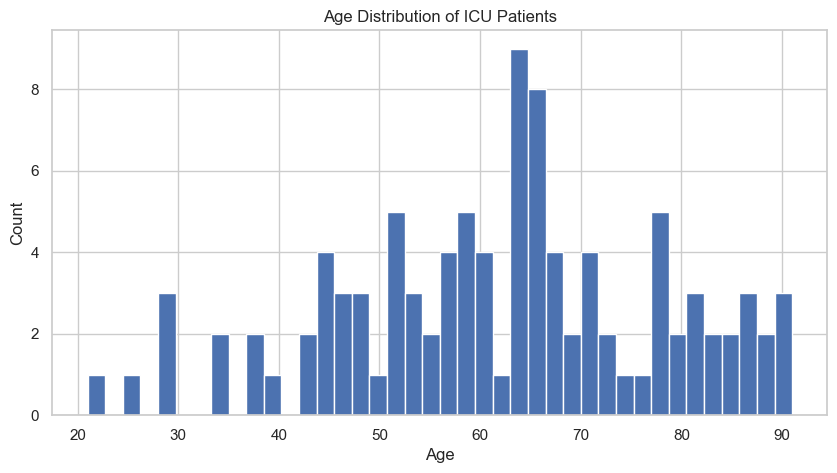

In [9]:
patients["anchor_age"].hist(bins=40)
plt.title("Age Distribution of ICU Patients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


Most ICU patients are older adults, with the highest concentration in the 50–70 years age range, indicating increased ICU admissions with advancing age.
Fewer patients are at the extremes of age (below 30 and above 85), showing that ICU admissions are less common in very young and very elderly groups.


Age vs Outcome (nutrition risk proxy)

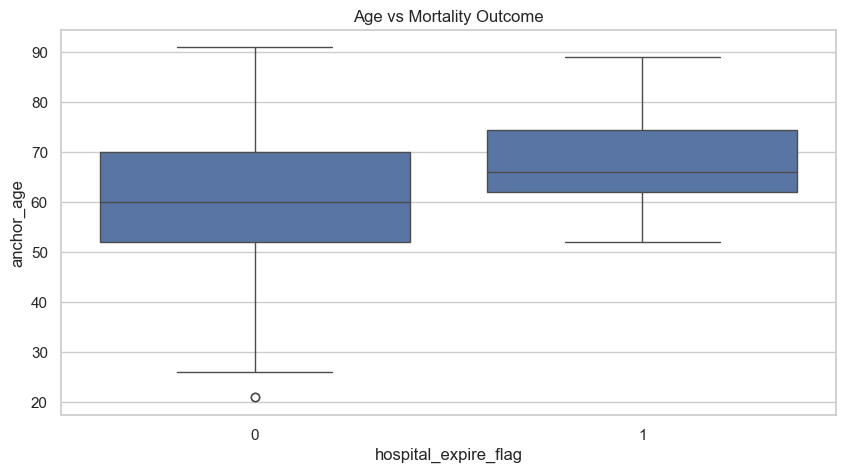

In [10]:
demo = admissions.merge(patients, on="subject_id")
sns.boxplot(x="hospital_expire_flag", y="anchor_age", data=demo)
plt.title("Age vs Mortality Outcome")
plt.show()


* **Patients who died (hospital_expire_flag = 1) have a higher median age** than survivors, indicating mortality increases with advancing age.

* **Survivors show a wider age spread**, including younger patients, while deaths are more concentrated in the **older age group (≈60–75 years)**.


Length of Stay (Catabolic Risk)

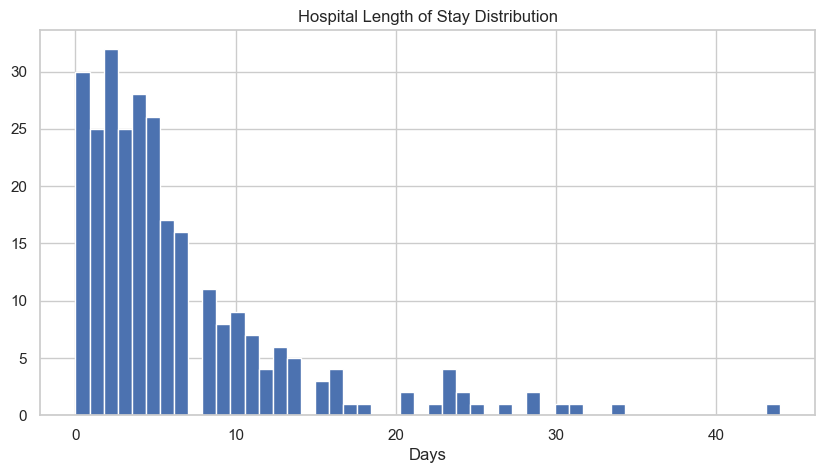

In [11]:
admissions["admittime"] = pd.to_datetime(admissions["admittime"])
admissions["dischtime"] = pd.to_datetime(admissions["dischtime"])

admissions["los_days"] = (
    admissions["dischtime"] - admissions["admittime"]
).dt.days

admissions["los_days"].hist(bins=50)
plt.title("Hospital Length of Stay Distribution")
plt.xlabel("Days")
plt.show()


ICU Stay Durations

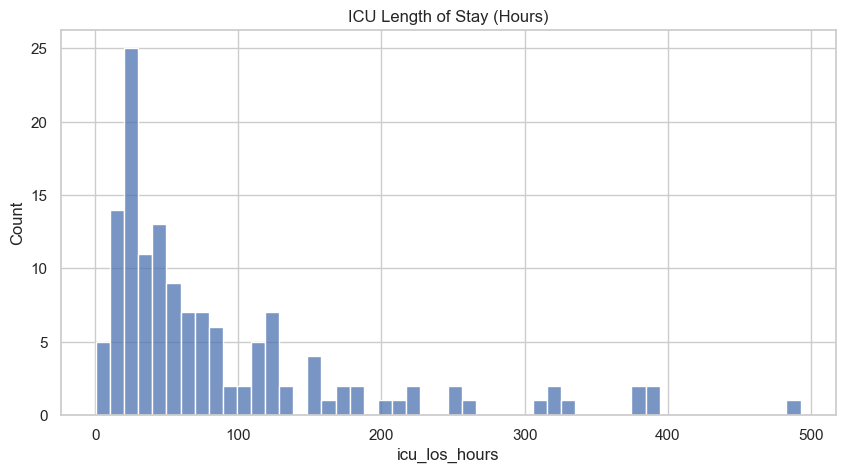

In [12]:
icustays["intime"] = pd.to_datetime(icustays["intime"])
icustays["outtime"] = pd.to_datetime(icustays["outtime"])

icustays["icu_los_hours"] = (
    icustays["outtime"] - icustays["intime"]
).dt.total_seconds() / 3600

sns.histplot(icustays["icu_los_hours"], bins=50)
plt.title("ICU Length of Stay (Hours)")
plt.show()


ICU length of stay is right-skewed, with most patients staying less than ~100 hours, indicating short to moderate ICU admissions are common.

A small number of patients have very long stays (200–500 hours), representing severe or complicated cases that act as outliers.


Missing Value Heatmap (CRITICAL)

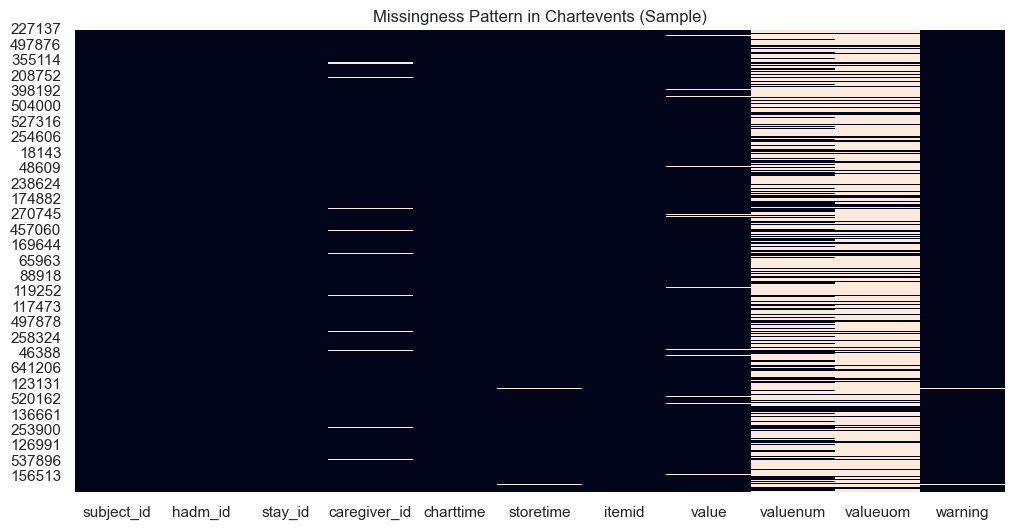

In [13]:
plt.figure(figsize=(12,6))
sns.heatmap(
    chartevents.sample(20000).isnull(),
    cbar=False
)
plt.title("Missingness Pattern in Chartevents (Sample)")
plt.show()


Significant missingness is present in measurement-related fields (especially `valuenum`, `valueuom`, and `value`), indicating that many chart events lack recorded numeric values.

Identifier and time-related fields are mostly complete, showing missing data is not random and must be handled carefully (e.g., imputation or masking) before ML/LSTM modeling.


Vital Sign Coverage

In [14]:
vital_ids = {
    220045: "Heart Rate",
    220179: "SysBP",
    220180: "DiaBP",
    220210: "RespRate",
    220277: "SpO2",
    223761: "Temperature"
}

vitals = chartevents[chartevents["itemid"].isin(vital_ids)]


Frequency of vitals

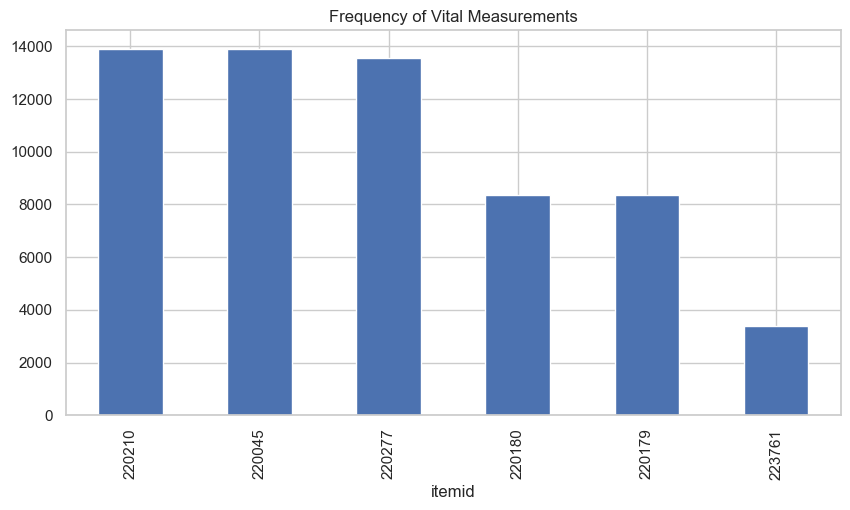

In [15]:
vitals["itemid"].value_counts().plot(kind="bar")
plt.title("Frequency of Vital Measurements")
plt.show()


* **Core vital signs are recorded most frequently**, with item IDs **220210, 220045, and 220277** showing the highest counts, indicating routine and continuous monitoring in ICU.

* **Some vitals are measured less often** (e.g., item ID **223761**), reflecting selective or condition-based monitoring rather than continuous measurement.


Distribution of Individual Vitals

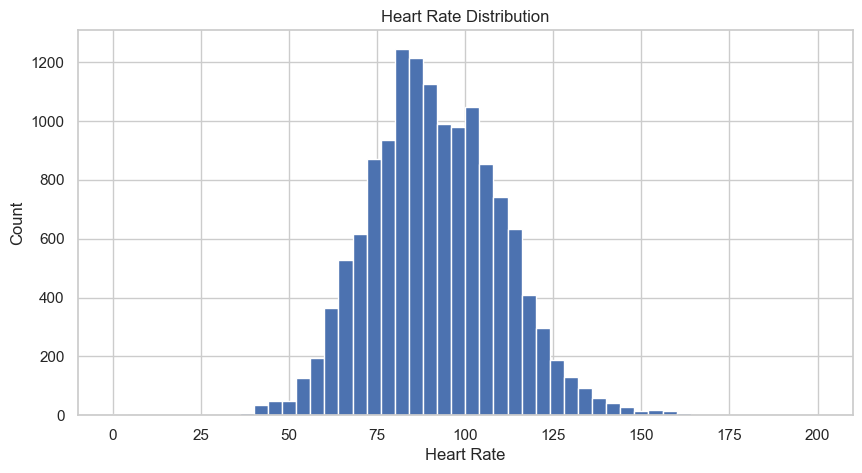

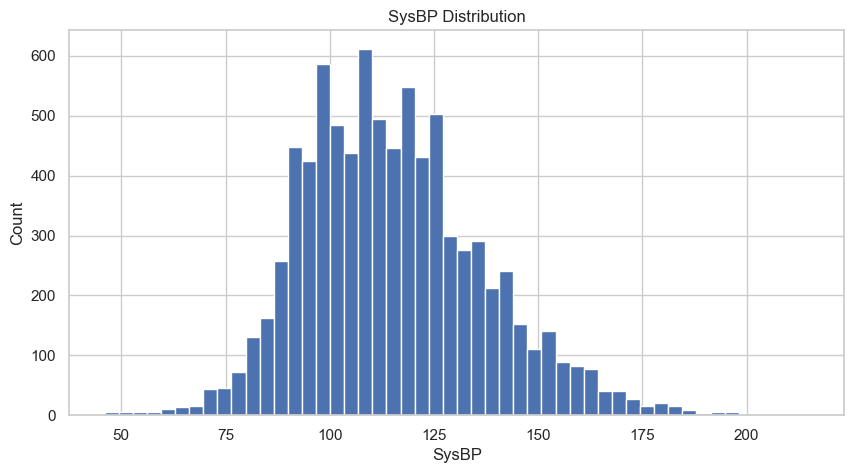

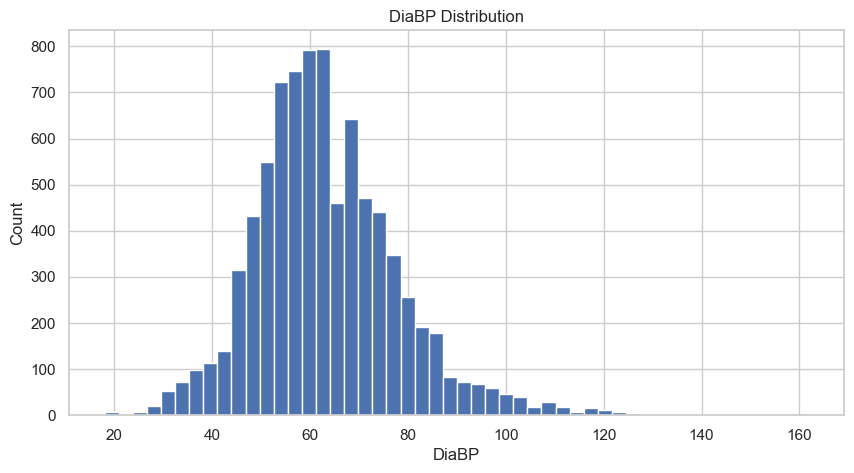

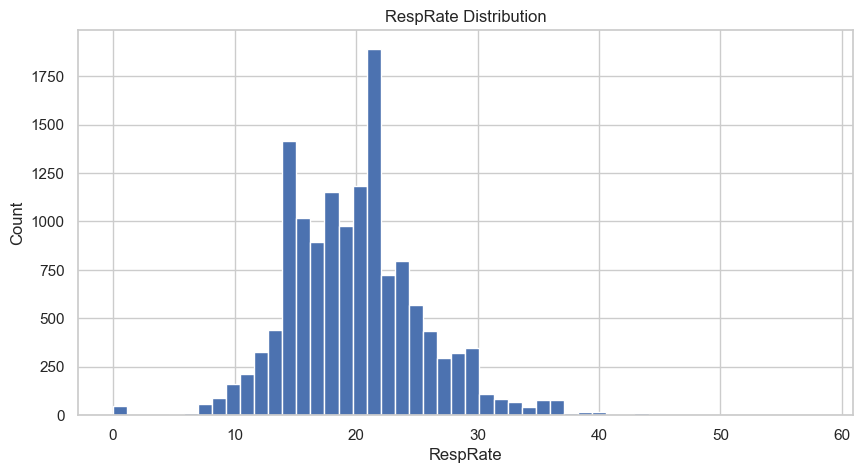

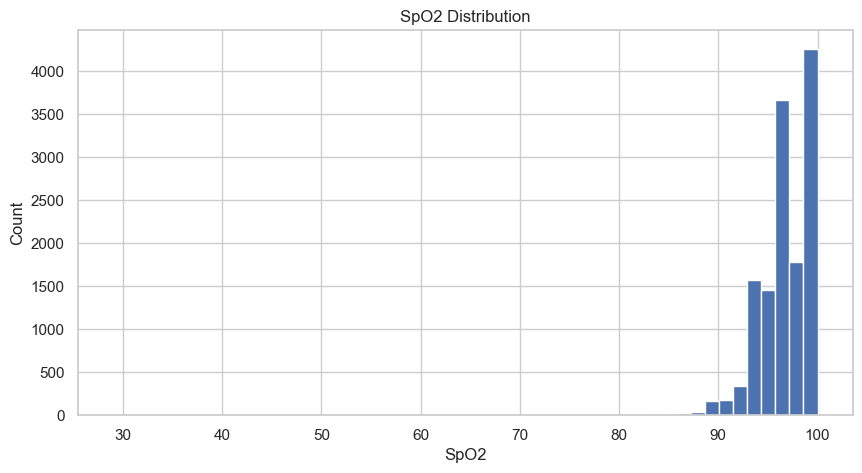

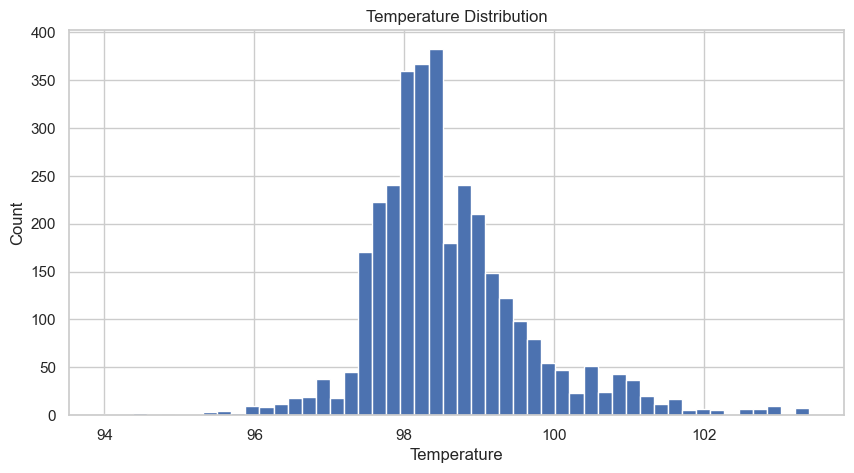

In [16]:
for itemid, name in vital_ids.items():
    data = vitals[vitals["itemid"] == itemid]["valuenum"].dropna()
    plt.hist(data, bins=50)
    plt.title(f"{name} Distribution")
    plt.xlabel(name)
    plt.ylabel("Count")
    plt.show()


* **Heart Rate:** Most values cluster around **70–100 bpm**, indicating predominantly normal heart rates with few extremes.

* **Systolic BP (SysBP):** Concentrated around **100–130 mmHg**, with a right-skew showing occasional hypertension.

* **Diastolic BP (DiaBP):** Mostly centered near **60–80 mmHg**, reflecting typical diastolic pressures.

* **Respiratory Rate:** Peaks around **15–25 breaths/min**, consistent with normal to mildly elevated respiration.

* **SpO₂:** Highly concentrated near **95–100%**, indicating generally adequate oxygenation.

* **Temperature:** Centered around **98–99°F**, with slight spread indicating mild fever or hypothermia in some patients.


Time-Series Fluctuation (Single ICU Stay)

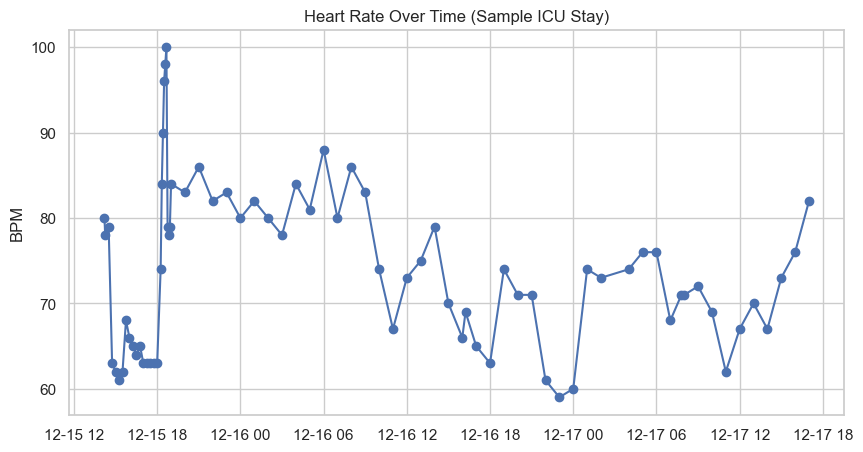

In [17]:
sample_stay = vitals["stay_id"].dropna().unique()[0]

hr = vitals[
    (vitals["stay_id"] == sample_stay) &
    (vitals["itemid"] == 220045)
].copy()

hr["charttime"] = pd.to_datetime(hr["charttime"])
hr = hr.sort_values("charttime")

plt.plot(hr["charttime"], hr["valuenum"], marker="o")
plt.title("Heart Rate Over Time (Sample ICU Stay)")
plt.ylabel("BPM")
plt.show()


* **Heart rate shows short-term fluctuations with an early spike**, likely reflecting acute stress or intervention during the initial ICU period.

* **Values stabilize between ~65–85 BPM over time**, indicating gradual physiological stabilization with occasional variability.


Lab Test Availability

In [18]:
lab_ids = {
    50931: "Glucose",
    50912: "Creatinine",
    50983: "Sodium",
    50971: "Potassium",
    51222: "Hemoglobin",
    50813: "Lactate"
}

labs = labevents[labevents["itemid"].isin(lab_ids)]


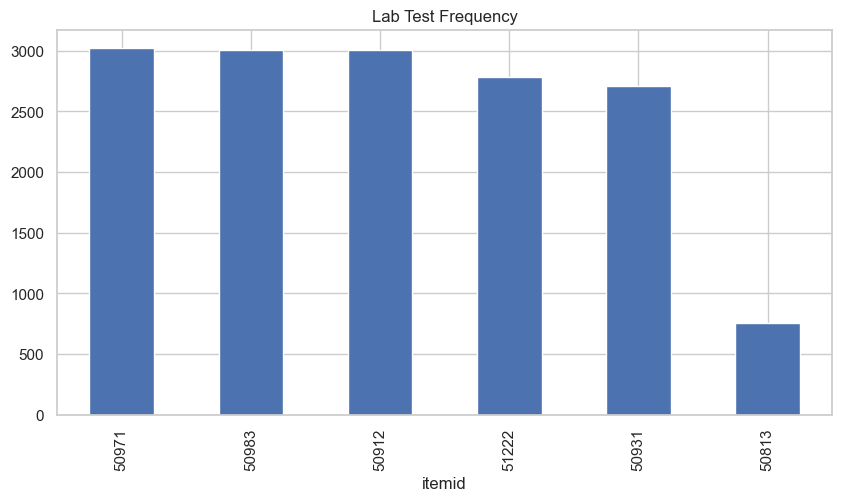

In [19]:
labs["itemid"].value_counts().plot(kind="bar")
plt.title("Lab Test Frequency")
plt.show()


Lab Value Distributions

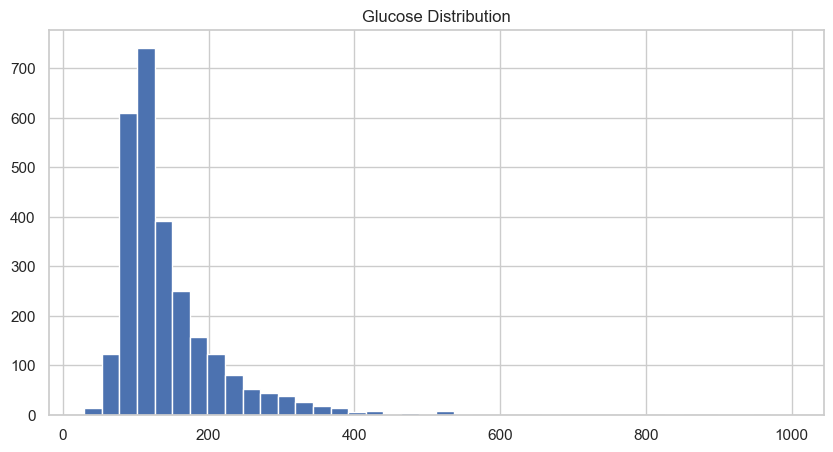

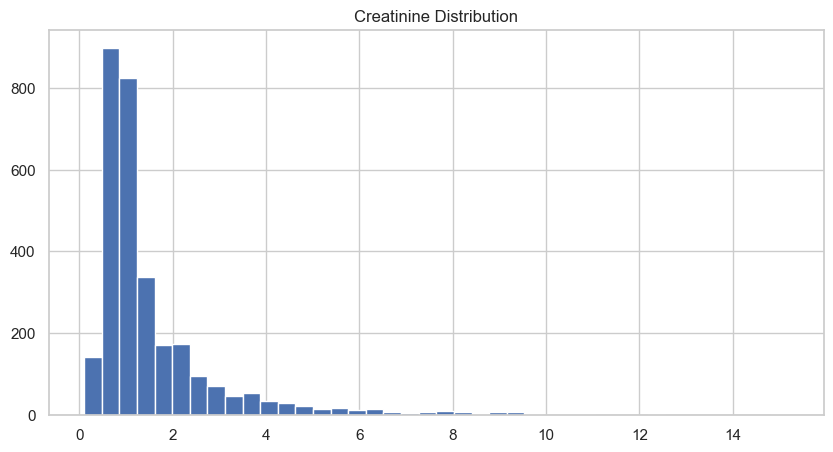

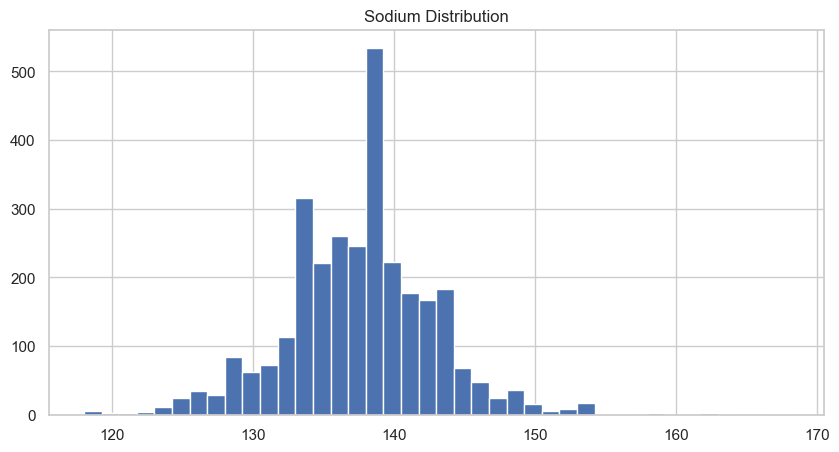

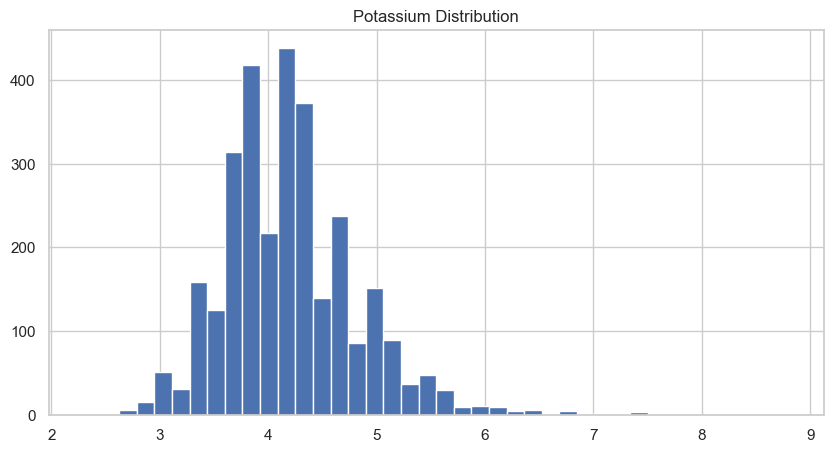

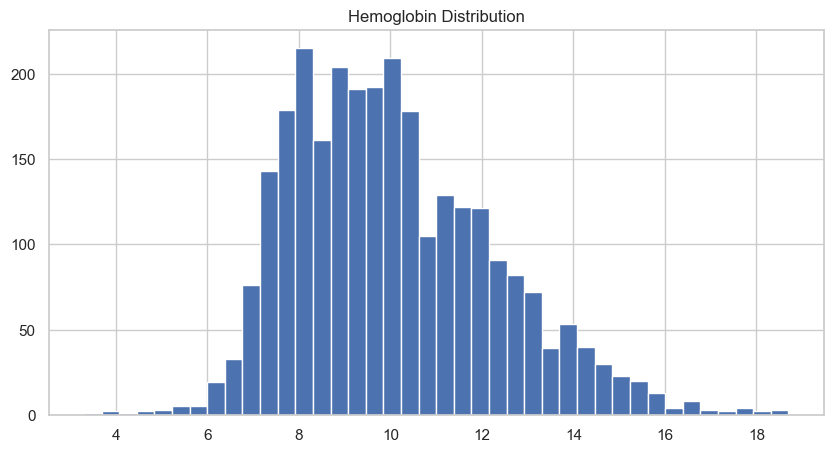

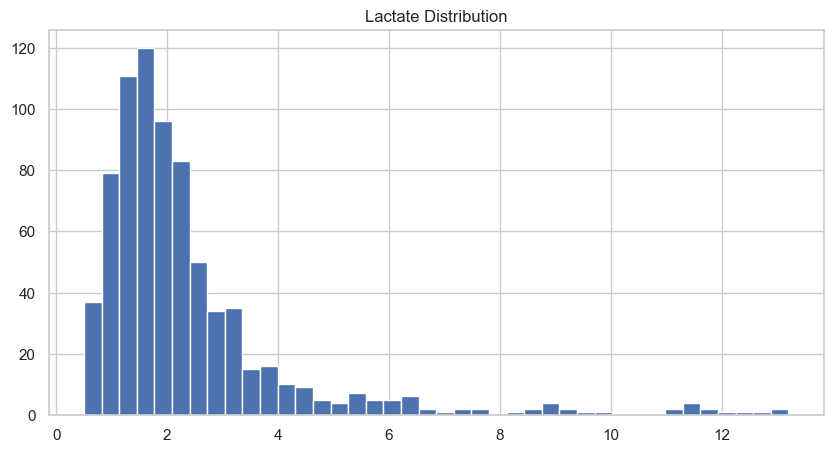

In [20]:
for itemid, name in lab_ids.items():
    values = labs[labs["itemid"] == itemid]["valuenum"].dropna()
    plt.hist(values, bins=40)
    plt.title(f"{name} Distribution")
    plt.show()


* **Glucose:** Right-skewed distribution with most values around **100–180 mg/dL**, and a long tail indicating episodes of **hyperglycemia**.

* **Sodium:** Tightly clustered around **135–145 mEq/L**, showing generally stable electrolyte levels with few hypo- or hypernatremia outliers.


Lab Sparsity (Why Imputation Is Dangerous)

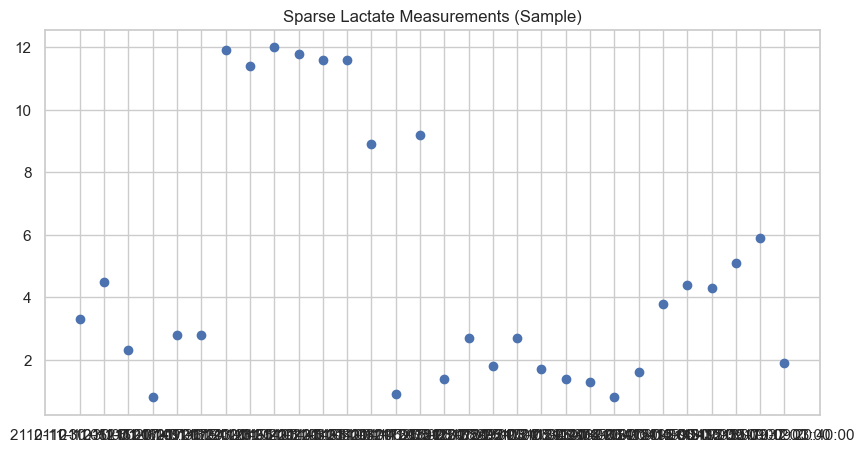

In [21]:
sample_lab = labs[labs["itemid"] == 50813]  # Lactate
sample_lab = sample_lab.sort_values("charttime").head(30)

plt.scatter(sample_lab["charttime"], sample_lab["valuenum"])
plt.title("Sparse Lactate Measurements (Sample)")
plt.show()


Fluid Input vs Output

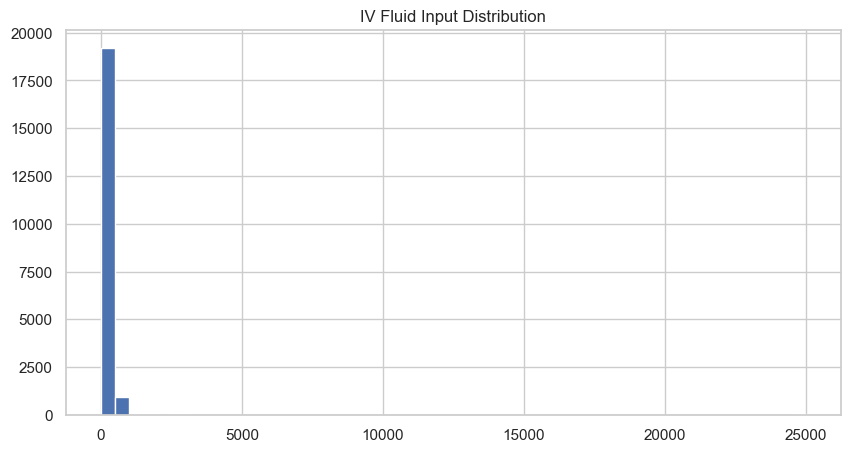

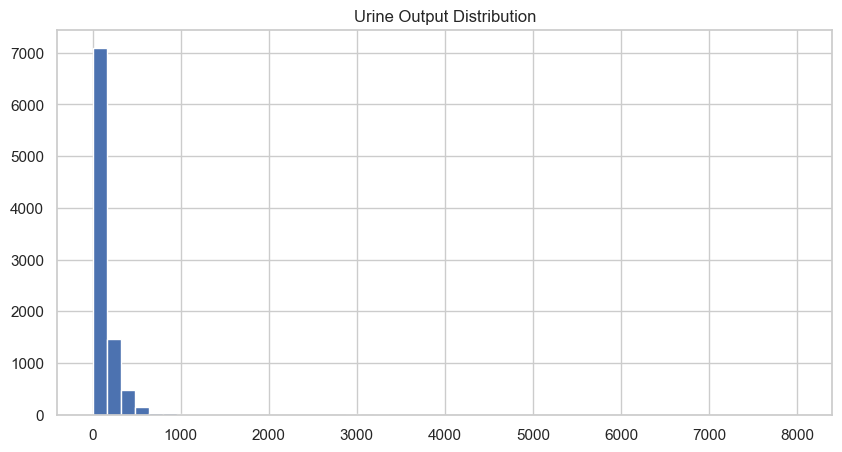

In [22]:
inp = inputevents.copy()
out = outputevents.copy()

inp["starttime"] = pd.to_datetime(inp["starttime"])
out["charttime"] = pd.to_datetime(out["charttime"])

inp["amount"].hist(bins=50)
plt.title("IV Fluid Input Distribution")
plt.show()

out["value"].hist(bins=50)
plt.title("Urine Output Distribution")
plt.show()


Hourly Fluid Balance (Single ICU Stay)

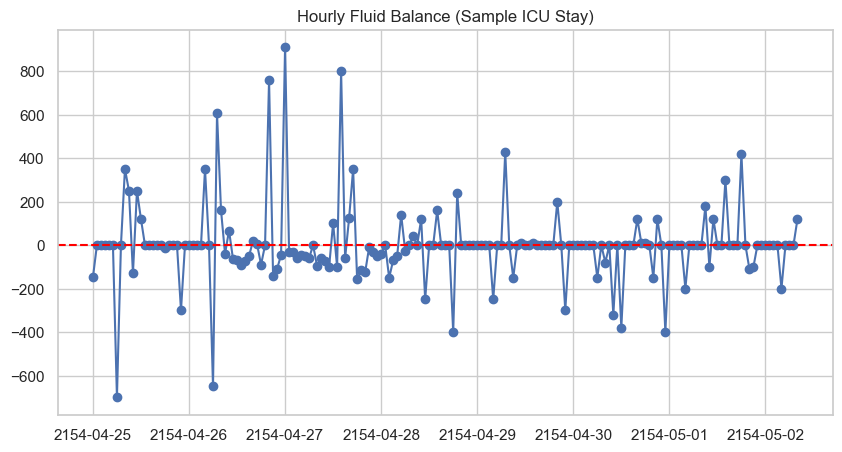

In [23]:
sid = icustays["stay_id"].iloc[0]

i = inp[inp["stay_id"] == sid].set_index("starttime")["amount"].resample("h").sum()
o = out[out["stay_id"] == sid].set_index("charttime")["value"].resample("h").sum()

fb = i - o

plt.plot(fb.index, fb.values, marker="o")
plt.title("Hourly Fluid Balance (Sample ICU Stay)")
plt.axhline(0, color="red", linestyle="--")
plt.show()


The graph shows hourly fluctuations in ICU fluid balance, where positive values indicate fluid gain and negative values indicate fluid loss, highlighting the dynamic fluid management in critically ill patient

Medication Usage Frequency

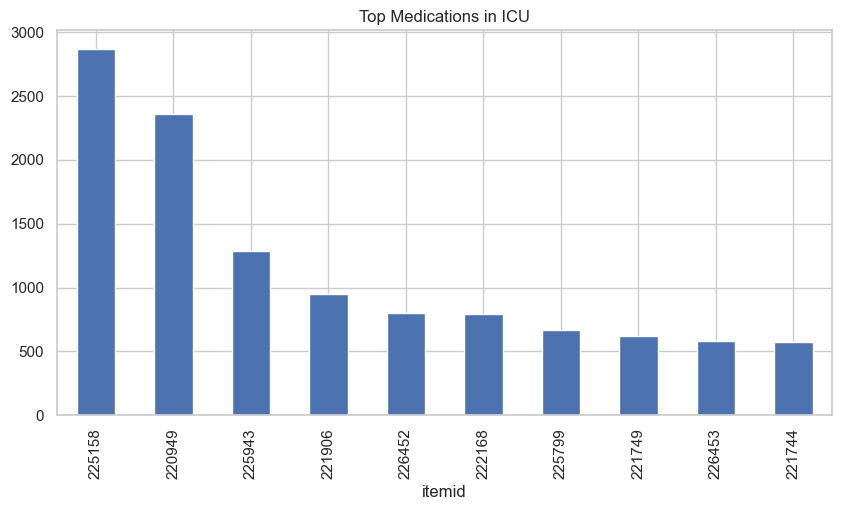

In [24]:
top_meds = inputevents["itemid"].value_counts().head(10)
top_meds.plot(kind="bar")
plt.title("Top Medications in ICU")
plt.show()


Correlation Heatmap (Vitals Only)

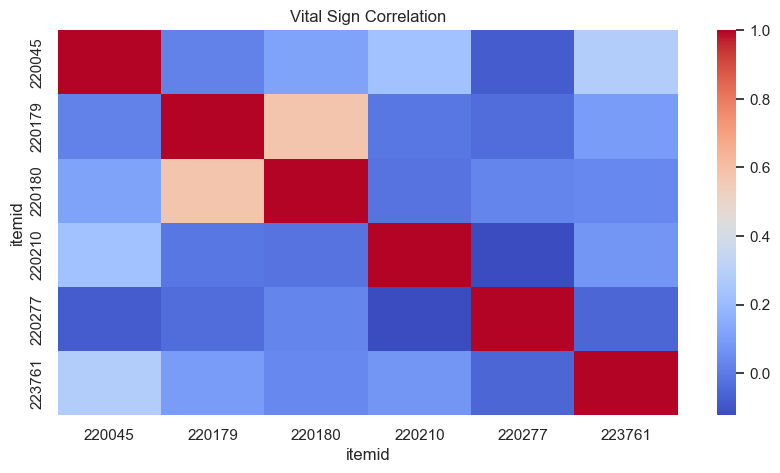

In [25]:
vital_wide = vitals.pivot_table(
    index=["stay_id", "charttime"],
    columns="itemid",
    values="valuenum"
)

sns.heatmap(vital_wide.corr(), cmap="coolwarm")
plt.title("Vital Sign Correlation")
plt.show()


* **Systolic and diastolic blood pressure show a strong positive correlation**, indicating they tend to increase or decrease together.

* **Most other vital signs have weak or near-zero correlations**, suggesting they capture largely independent physiological information.


Outcome vs Physiology (Sanity Check)

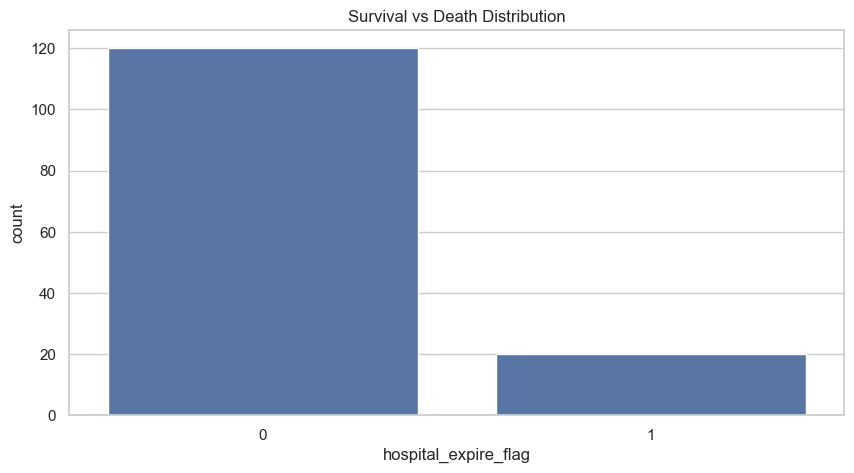

In [26]:
merged = icustays.merge(
    admissions[["hadm_id", "hospital_expire_flag"]],
    on="hadm_id"
)

sns.countplot(x="hospital_expire_flag", data=merged)
plt.title("Survival vs Death Distribution")
plt.show()
